In [2]:
import pandas as pd

result_file = "../results.csv"
results = pd.read_csv(result_file, index_col=0)
results.head()

,trans,past_context,gpos,gquat,npss,data_index,sequence_filename
0,15,0,0.038525,0.054768,9.460606e-09,0,aiming2_subject5.bvh
1,15,0,0.193839,0.159822,1.431699e-06,1,aiming2_subject5.bvh
2,15,0,0.429415,0.253881,6.782425e-06,2,aiming2_subject5.bvh
3,15,0,0.341472,0.173236,3.130861e-06,3,aiming2_subject5.bvh
4,15,0,0.390053,0.267045,4.663586e-06,4,aiming2_subject5.bvh


In [22]:
print(results["trans"].unique())
print(results["sequence_filename"].unique())
print(results["past_context"].unique())

[15 30 45]
['aiming2_subject5.bvh' 'dance2_subject5.bvh' 'fallAndGetUp1_subject5.bvh'
 'fight1_subject5.bvh' 'ground1_subject5.bvh' 'jumps1_subject5.bvh'
 'obstacles1_subject5.bvh' 'obstacles2_subject5.bvh'
 'obstacles6_subject5.bvh' 'pushAndStumble1_subject5.bvh'
 'run1_subject5.bvh' 'walk1_subject5.bvh' 'walk3_subject5.bvh']
[0 1 2 3 4 5 6 7 8 9]


group per transition length, then by sequence_filename and calculate mean of each of metrics

Metric: gpos


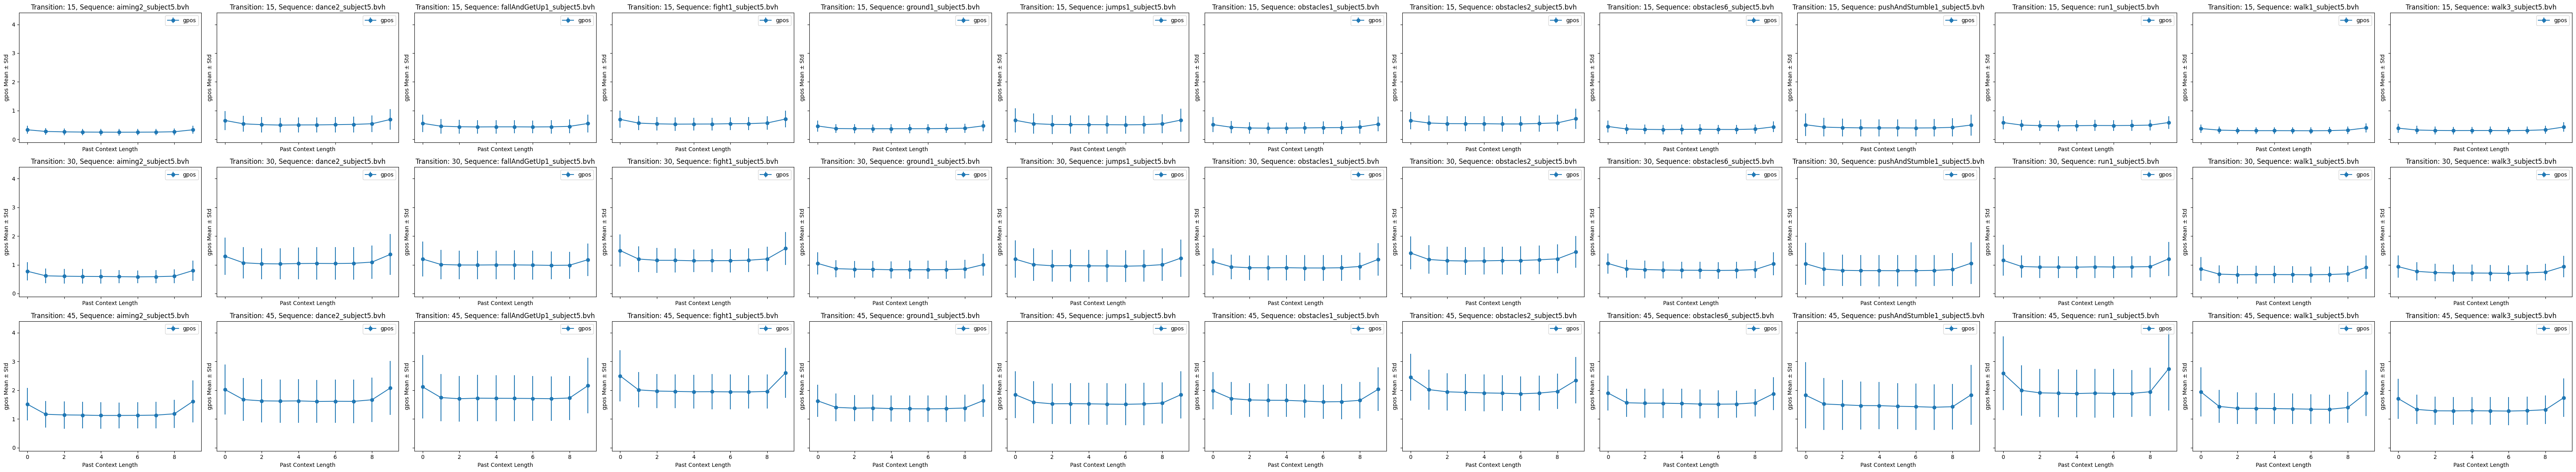

Metric: gquat


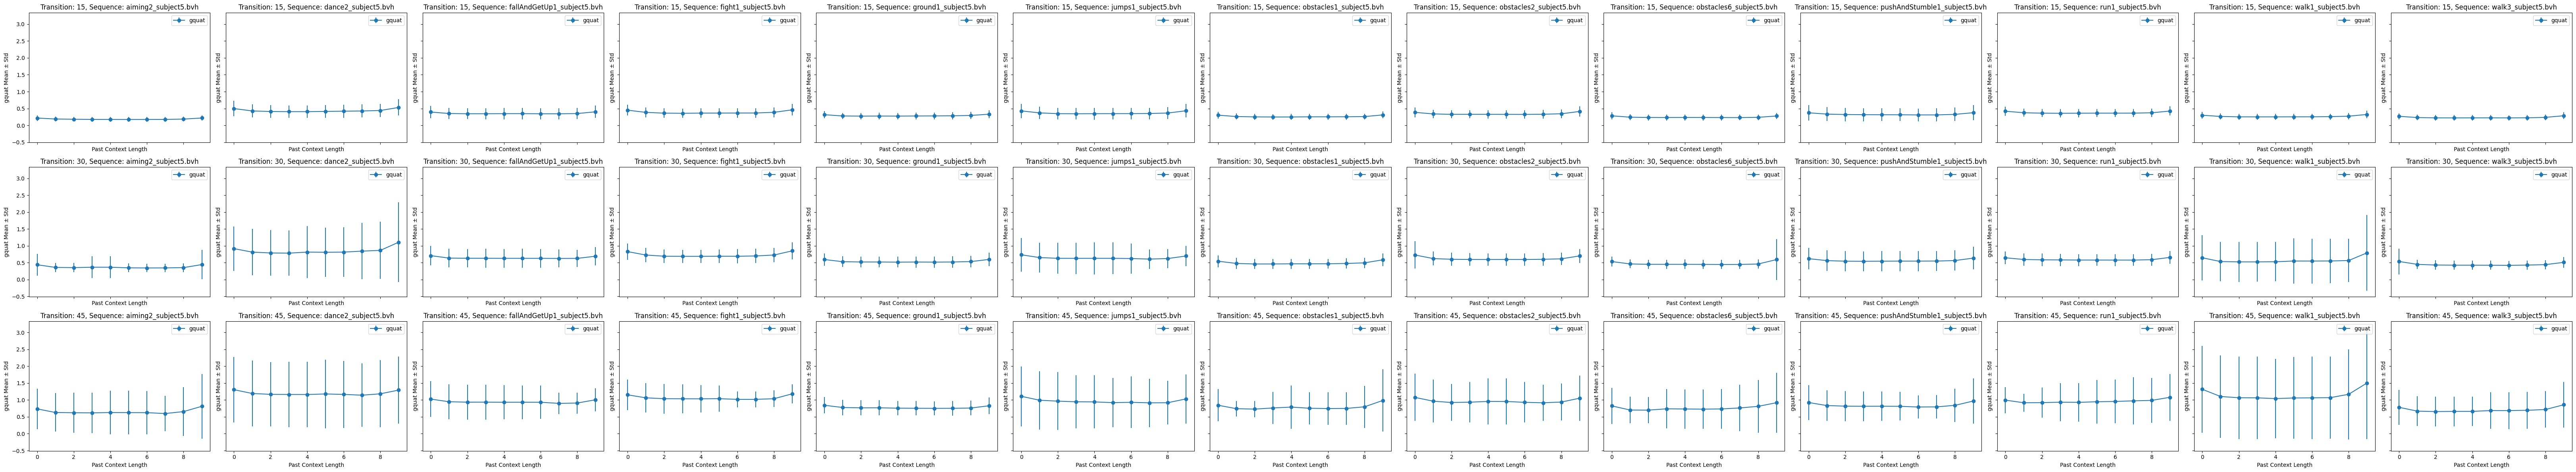

Metric: npss


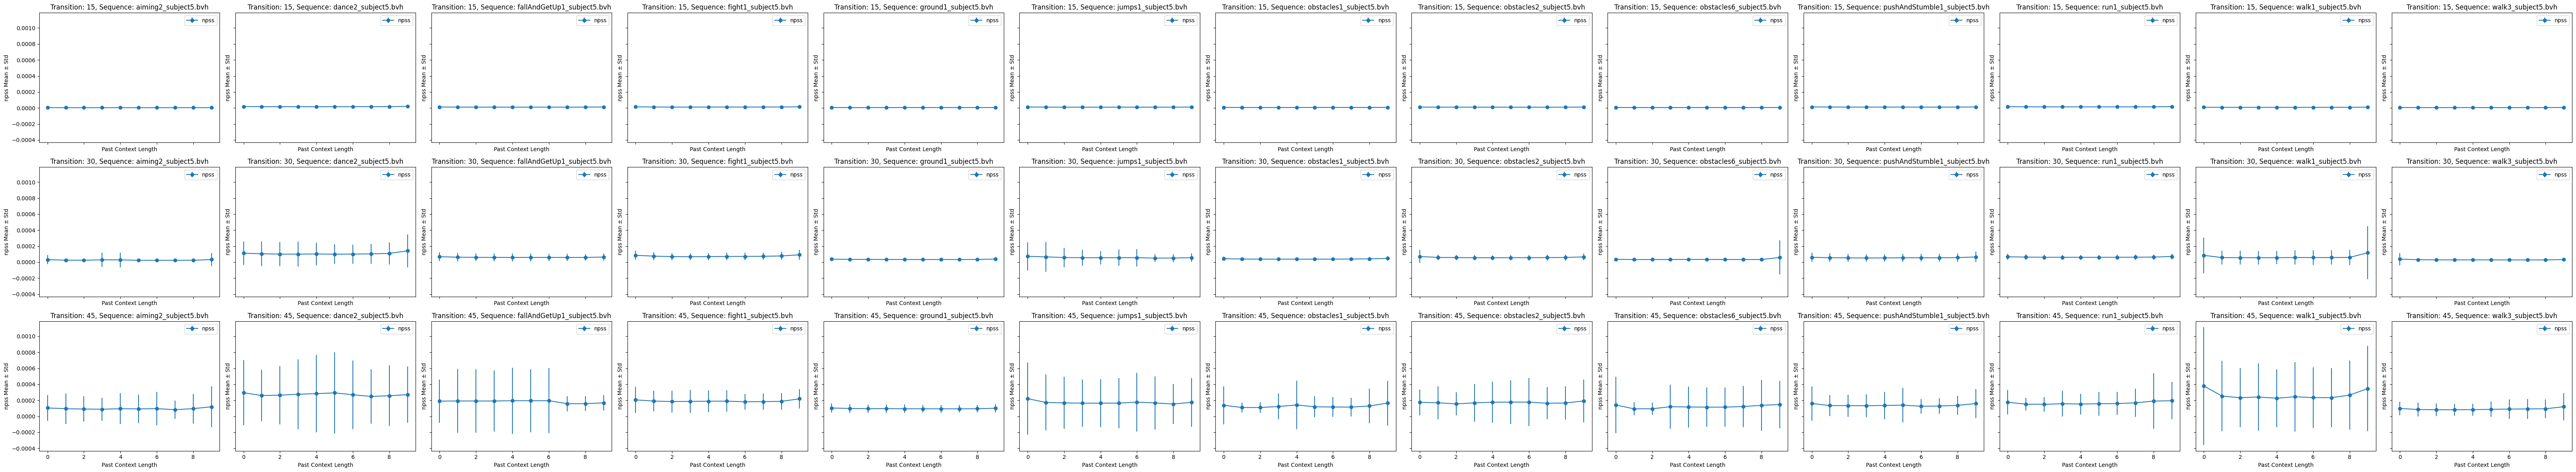

In [ ]:
import matplotlib.pyplot as plt
grouped = results.groupby(['trans', 'sequence_filename', 'past_context']).agg(["mean", "std"]).drop(columns=['data_index'])

trans_values = results["trans"].unique()
seq_values = results["sequence_filename"].unique()


for metric in ['gpos', 'gquat', 'npss']:
    print(f"Metric: {metric}")
    fig, axes = plt.subplots(len(trans_values),len(seq_values),  figsize=(5 * len(seq_values), 4 * len(trans_values)), sharex=True, sharey=True)

    for row, t in enumerate(trans_values):
        for col, seq in enumerate(seq_values):
            ax = axes[row, col]
            data = grouped.loc[(t, seq)]
            x = data.index.get_level_values('past_context')
            m_mean = data[metric]['mean']
            m_std = data[metric]['std']
            ax.errorbar(x, m_mean, yerr=m_std, label=metric, fmt='-o')
            ax.set_title(f"Transition: {t}, Sequence: {seq}")
            ax.set_xlabel('Past Context Length')
            ax.set_ylabel(metric +' Mean ± Std')
            ax.legend()
    plt.tight_layout()
    plt.show()
            


In [9]:
results["data_index"]

0           0
1           1
2           2
3           3
4           4
         ... 
66955    2227
66956    2228
66957    2229
66958    2230
66959    2231
Name: data_index, Length: 66960, dtype: int64

In [ ]:
#group without sequence_filename
grouped_no_seq = results.drop(columns=["sequence_filename", "data_index"]).groupby(['trans', 'past_context']).agg(["mean", "std", "sum"])
grouped_no_seq.head()

gpos                            gquat            \
                        mean       std          sum      mean       std   
trans past_context                                                        
15    0             0.520675  0.297227  1162.145571  0.353515  0.172373   
      1             0.432659  0.250007   965.695838  0.308252  0.150532   
      2             0.413158  0.238870   922.168964  0.295914  0.145147   
      3             0.406805  0.234481   907.988860  0.293589  0.144276   
      4             0.408162  0.235070   911.017257  0.294502  0.145177   

                                    npss                      
                           sum      mean       std       sum  
trans past_context                                            
15    0             789.046487  0.000010  0.000010  0.023046  
      1             688.019180  0.000009  0.000009  0.020494  
      2             660.480264  0.000009  0.000008  0.019660  
      3             655.290267  0.000009  0.000008  0.019591  
      4             657.328446  0.000009  0.000008  0.019801

In [18]:
grouped_no_seq.reset_index()

trans past_context      gpos                            gquat            \
                           mean       std          sum      mean       std   
0     15            0  0.520675  0.297227  1162.145571  0.353515  0.172373   
1     15            1  0.432659  0.250007   965.695838  0.308252  0.150532   
2     15            2  0.413158  0.238870   922.168964  0.295914  0.145147   
3     15            3  0.406805  0.234481   907.988860  0.293589  0.144276   
4     15            4  0.408162  0.235070   911.017257  0.294502  0.145177   
5     15            5  0.408529  0.236127   911.836080  0.295582  0.145623   
6     15            6  0.408598  0.235526   911.989761  0.295559  0.146699   
7     15            7  0.414172  0.240273   924.431331  0.297876  0.147820   
8     15            8  0.432326  0.249012   964.951245  0.309927  0.151061   
9     15            9  0.534351  0.300672  1192.672211  0.364677  0.175556   
10    30            0  1.110634  0.560760  2478.936080  0.647677  0.412457   
11    30            1  0.911614  0.464282  2034.721521  0.565637  0.352404   
12    30            2  0.880936  0.453017  1966.248240  0.549466  0.351594   
13    30            3  0.875761  0.450949  1954.697703  0.548605  0.361255   
14    30            4  0.874052  0.449661  1950.884747  0.551073  0.376853   
15    30            5  0.874270  0.452802  1951.369699  0.551206  0.371653   
16    30            6  0.870602  0.450627  1943.183529  0.549777  0.369341   
17    30            7  0.879381  0.453403  1962.778638  0.553619  0.372278   
18    30            8  0.907635  0.464969  2025.840722  0.568253  0.372944   
19    30            9  1.141286  0.580747  2547.350617  0.678509  0.572772   
20    45            0  1.999845  0.918949  4463.654611  0.996734  0.718719   
21    45            1  1.617696  0.714463  3610.697790  0.886076  0.667156   
22    45            2  1.571411  0.693428  3507.389854  0.868345  0.664555   
23    45            3  1.565305  0.689802  3493.761545  0.873055  0.687411   
24    45            4  1.557808  0.684346  3477.027061  0.873628  0.696014   
25    45            5  1.549949  0.684250  3459.486097  0.875164  0.704174   
26    45            6  1.542132  0.680591  3442.037927  0.870122  0.690536   
27    45            7  1.545281  0.676443  3449.067327  0.867612  0.672388   
28    45            8  1.586324  0.687055  3540.674828  0.903081  0.728782   
29    45            9  2.029517  0.937305  4529.881183  1.045051  0.874811   

                     npss                      
            sum      mean       std       sum  
0    789.046487  0.000010  0.000010  0.023046  
1    688.019180  0.000009  0.000009  0.020494  
2    660.480264  0.000009  0.000008  0.019660  
3    655.290267  0.000009  0.000008  0.019591  
4    657.328446  0.000009  0.000008  0.019801  
5    659.738898  0.000009  0.000008  0.019940  
6    659.688524  0.000009  0.000008  0.019898  
7    664.858518  0.000009  0.000008  0.019934  
8    691.757365  0.000009  0.000008  0.020389  
9    813.958968  0.000011  0.000010  0.023766  
10  1445.615674  0.000062  0.000106  0.139001  
11  1262.501709  0.000054  0.000081  0.120113  
12  1226.409160  0.000051  0.000069  0.114826  
13  1224.485314  0.000051  0.000071  0.114500  
14  1229.995882  0.000051  0.000068  0.114852  
15  1230.290773  0.000051  0.000062  0.114424  
16  1227.101429  0.000051  0.000063  0.114548  
17  1235.678165  0.000051  0.000057  0.114842  
18  1268.340983  0.000053  0.000061  0.118763  
19  1514.431741  0.000068  0.000140  0.152127  
20  2224.711373  0.000186  0.000336  0.414546  
21  1977.720584  0.000155  0.000242  0.345261  
22  1938.145736  0.000150  0.000227  0.335069  
23  1948.658248  0.000156  0.000262  0.348373  
24  1949.938511  0.000158  0.000272  0.351984  
25  1953.365323  0.000160  0.000281  0.356107  
26  1942.113367  0.000157  0.000267  0.349558  
27  1936.510255  0.000151  0.000221  0.337943  
28  2015.677126  0.000160  0.000258  0.358093  
29  2332.553259  0

In [11]:
trans_values = grouped_no_seq["trans"].unique()

for metric in ['gpos', 'gquat']:
    print(f"Metric: {metric}")
    fig, axes = plt.subplots(len(trans_values),len(seq_values),  figsize=(5, 4 * len(trans_values)), sharex=True, sharey=True)

    for row, t in enumerate(trans_values):
        ax = axes[row, col]
        data = grouped.loc[(t, seq)]
        x = data.index.get_level_values('past_context')
        m_mean = data[metric]['mean']
        m_std = data[metric]['std']
        ax.errorbar(x, m_mean, yerr=m_std, label=metric, fmt='-o')
        ax.set_title(f"Transition: {t}, Sequence: {seq}")
        ax.set_xlabel('Past Context Length')
        ax.set_ylabel(metric +' Mean ± Std')
        ax.legend()
    plt.tight_layout()
    plt.show()
    

metric = 'npss'
print(f"Metric: {metric}")
fig, axes = plt.subplots(len(trans_values),len(seq_values),  figsize=(5, 4 * len(trans_values)), sharex=True, sharey=True)

for row, t in enumerate(trans_values):
    ax = axes[row, col]
    data = grouped.loc[(t, seq)]
    x = data.index.get_level_values('past_context')
    npss_sum = data[metric]['sum']
    ax.line(x, npss_sum, label=metric, fmt='-o')
    ax.set_title(f"Transition: {t}, Sequence: {seq}")
    ax.set_xlabel('Past Context Length')
    ax.set_ylabel(metric +' Weighted avg')
    ax.legend()
plt.tight_layout()
plt.show()
            

KeyError: 'trans'

# NPSS experiments

in paper experiments npss weights are normalized across whole benchmark dataset and then multiplied, summed. Problem is when I want to asses performance of model on each file seperately. This requires different level of aggregation and i want to see how results will look like on normalizing them across file/single interpolation.

In [1]:
import pandas as pd

result_file = "../results2.pickle"
results = pd.read_pickle(result_file)
results.head()

,trans,past_context,gpos,gquat,npss,npss_weights,data_index,sequence_filename
0,15,0,0.038525,0.054768,"[3.6566687, 0.0, 0.0, 3.8205283, 0.0, 0.000725...","[0.00087469956, 115.243126, 109.75571, 0.00013...",0,aiming2_subject5.bvh
1,15,0,0.193839,0.159821,"[2.592054, 3.3080578e-05, 3.129244e-05, 1.5963...","[0.07384283, 117.3792, 107.4868, 0.027556384, ...",1,aiming2_subject5.bvh
2,15,0,0.429415,0.253881,"[0.015756905, 0.0002090931, 0.00044077635, 0.1...","[4.8030963, 123.55441, 88.740974, 3.80926, 167...",2,aiming2_subject5.bvh
3,15,0,0.341472,0.173236,"[1.7902017, 7.683039e-05, 4.4345856e-05, 0.010...","[0.03334993, 128.98517, 95.44024, 0.43521613, ...",3,aiming2_subject5.bvh
4,15,0,0.390053,0.267045,"[0.10176784, 0.00079387426, 0.00092458725, 0.0...","[0.86120355, 120.2206, 101.48361, 1.9824837, 1...",4,aiming2_subject5.bvh


In [9]:
results["npss_weights"].iloc[12].shape

(88,)

In [16]:
import numpy as np
results["npss_weighted"] = (results["npss"] * results["npss_weights"]).apply(np.sum, axis=0)
results["npss_weighted"]

0            0.102850
1           15.564636
2           73.734772
3           34.036987
4           50.699921
             ...     
66955     5076.092773
66956     4274.698242
66957     6523.341309
66958    17517.722656
66959     6905.816406
Name: npss_weighted, Length: 66960, dtype: float32

In [17]:
results["npss_weights_sum"] =  results["npss_weights"].apply(np.sum, axis=0)
results["npss_weights_sum"]

0         4949.963867
1         4893.846680
2         4818.854004
3         4896.881348
4         4920.758789
             ...     
66955    44216.578125
66956    44181.429688
66957    43739.507812
66958    39836.824219
66959    41913.625000
Name: npss_weights_sum, Length: 66960, dtype: float32

Normalization per sequence

In [20]:
results["npss_normalized_per_sequence"] =  results["npss_weighted"] / results["npss_weights_sum"]
results["npss_normalized_per_sequence"]

0        0.000021
1        0.003180
2        0.015301
3        0.006951
4        0.010303
           ...   
66955    0.114801
66956    0.096753
66957    0.149141
66958    0.439737
66959    0.164763
Name: npss_normalized_per_sequence, Length: 66960, dtype: float32

In [19]:
results[['trans', 'sequence_filename', 'past_context','npss_weights_sum', 'npss_weighted' ]]

,trans,sequence_filename,past_context,npss_weights_sum,npss_weighted
0,15,aiming2_subject5.bvh,0,4949.963867,0.102850
1,15,aiming2_subject5.bvh,0,4893.846680,15.564636
2,15,aiming2_subject5.bvh,0,4818.854004,73.734772
3,15,aiming2_subject5.bvh,0,4896.881348,34.036987
4,15,aiming2_subject5.bvh,0,4920.758789,50.699921
...,...,...,...,...,...
66955,45,walk3_subject5.bvh,9,44216.578125,5076.092773
66956,45,walk3_subject5.bvh,9,44181.429688,4274.698242
66957,45,walk3_subject5.bvh,9,43739.507812,6523.341309
66958,45,walk3_subject5.bvh,9,39836.824219,17517.722656


In [ ]:
import matplotlib.pyplot as plt
grouped = results[['trans', 'sequence_filename', 'past_context', 'npss_normalized_per_sequence']].groupby(['trans', 'sequence_filename', 'past_context']).agg(["mean", "std"]).drop(columns=['data_index'])

trans_values = results["trans"].unique()
seq_values = results["sequence_filename"].unique()


fig, axes = plt.subplots(len(trans_values),len(seq_values),  figsize=(5 * len(seq_values), 4 * len(trans_values)), sharex=True, sharey=True)

for row, t in enumerate(trans_values):
    for col, seq in enumerate(seq_values):
        ax = axes[row, col]
        data = grouped.loc[(t, seq)]
        x = data.index.get_level_values('past_context')
        m_mean = data[metric]['mean']
        m_std = data[metric]['std']
        ax.errorbar(x, m_mean, yerr=m_std, label=metric, fmt='-o')
        ax.set_title(f"Transition: {t}, Sequence: {seq}")
        ax.set_xlabel('Past Context Length')
        ax.set_ylabel(metric +' Mean ± Std')
        ax.legend()
plt.tight_layout()
plt.show()
            


Normalization per file